In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np

# Data Cleaning & Preparation

## Import dataset

In [2]:
df=pd.read_csv(r'C:\Study\Final Project\breast-cancer.csv')

## Drop the useless column (The id columns is useless)

In [3]:
df_clean=df.drop('id',axis=1)  

## Convert the string values to numeric (The Class column "diagnosis" is the only one)

In [4]:
df_clean['diagnosis']=df_clean['diagnosis'].map({'M':1, 'B':0})

# Correlation

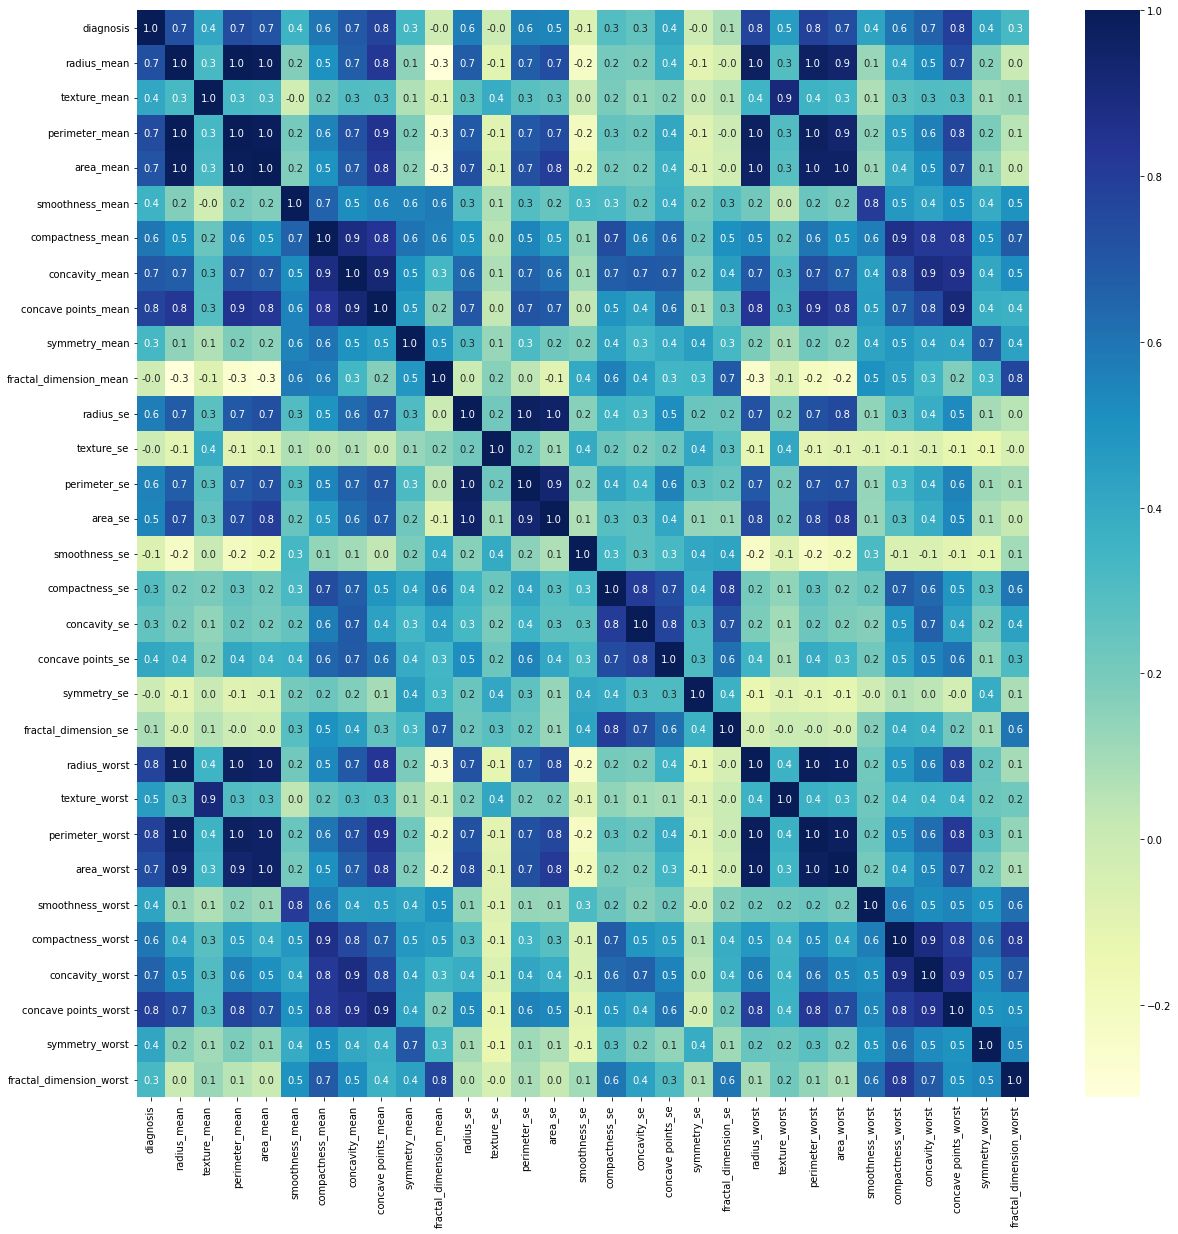

In [5]:
fig = plt.figure(figsize=(20,20))
sns.heatmap(df_clean.corr(),annot=True,cmap='YlGnBu',fmt='.1f')
plt.rcParams['figure.facecolor'] = 'white'

# Gain Ratio feature selection method to select features

### Calculate Entropy

In [6]:
def entropy(col, c=False):
    feature=df_clean[col]
    if c==True:
        pros=feature.value_counts(normalize=True)
        return -1 * np.sum(np.log2(pros) * pros)
    else:
        threshold=np.mean(feature)
        weight_less=df_clean[df_clean[col] <= threshold]
        weight_more=df_clean[df_clean[col] > threshold]
        
        p=[len(weight_less) / len(df_clean), len(weight_more) / len(df_clean)]
        
        entro_less=0
        entro_more=0
        for d in df_clean['diagnosis'].unique():
            weight_less_dia=weight_less[weight_less['diagnosis']==d]
            r_less=len(weight_less_dia) / len(weight_less)
            entro_less -= np.log2(r_less) * r_less
            
            weight_more_dia=weight_more[weight_more['diagnosis']==d]
            r_more=len(weight_more_dia) / len(weight_more)
            entro_more -= np.log2(r_more) * r_more
        
        return p[0] * entro_less + p[1] * entro_more   
            

In [7]:
entropy_class=entropy('diagnosis',c=True)
print('The entropy of class (diagnosis) is: %.2f' % entropy_class)

The entropy of class (diagnosis) is: 0.95


### Calculate Inforamtion Gain

In [8]:
def info_gain(col):
    return entropy_class-entropy(col)

### Calculate Spint Information

In [9]:
def split_info(col):
    feature=df_clean[col]
    threshold=np.mean(feature)
    weight_less=df_clean[df_clean[col] <= threshold]
    weight_more=df_clean[df_clean[col] > threshold]
    
    pros=pd.Series([len(weight_less) / len(df_clean), len(weight_more) / len(df_clean)])
    return -1 * np.sum(np.log2(pros) * pros)
    

### Calculate Gain Raio

In [10]:
def gain_ratio(col):
    return info_gain(col) / split_info(col)

In [11]:
cols=df_clean.columns[1:]
gain_ratios=[gain_ratio(col) for col in cols]

gainRatio=pd.DataFrame({'Features':cols, 'Gain Ratio': gain_ratios})
gainRatio.sort_values('Gain Ratio',ascending=False).reset_index(drop=True)

,Features,Gain Ratio
0,area_worst,0.608610
1,perimeter_worst,0.572704
2,concave points_mean,0.557111
3,radius_worst,0.535973
4,concave points_worst,0.504907
5,concavity_mean,0.464539
6,area_se,0.460266
7,perimeter_mean,0.425254
8,area_mean,0.423334
9,radius_mean,0.405891


# Feature Selection

In [12]:
selected_features=gainRatio[gainRatio['Gain Ratio']>0.1]['Features'] # Select the features whose gain ratio are greater than 0.1

df_clean=df_clean[['diagnosis']+selected_features.to_list()]

## Scale data

### Check the range of every features

In [13]:
ranges=pd.DataFrame({'Column': df_clean.columns,
                     'Min': [df_clean[col].min() for col in df_clean.columns],
                     'Max': [df_clean[col].max() for col in df_clean.columns]})

In [14]:
ranges

,Column,Min,Max
0,diagnosis,0.00000,1.00000
1,radius_mean,6.98100,28.11000
2,texture_mean,9.71000,39.28000
3,perimeter_mean,43.79000,188.50000
4,area_mean,143.50000,2501.00000
5,compactness_mean,0.01938,0.34540
6,concavity_mean,0.00000,0.42680
7,concave points_mean,0.00000,0.20120
8,radius_se,0.11150,2.87300
9,perimeter_se,0.75700,21.98000


### Some columns have large ranges and not all the columns stay at the same level. So the dataset need to be scaled.

In [15]:
scaler=MinMaxScaler()
df_scaled=pd.DataFrame(scaler.fit_transform(df_clean), columns=df_clean.columns)

In [16]:
df_scaled.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,compactness_mean,concavity_mean,concave points_mean,radius_se,perimeter_se,area_se,concavity_se,concave points_se,radius_worst,texture_worst,perimeter_worst,area_worst,compactness_worst,concavity_worst,concave points_worst
0,1.0,0.521037,0.022658,0.545989,0.363733,0.792037,0.703140,0.731113,0.356147,0.369034,0.273811,0.135682,0.300625,0.620776,0.141525,0.668310,0.450698,0.619292,0.568610,0.912027
1,1.0,0.643144,0.272574,0.615783,0.501591,0.181768,0.203608,0.348757,0.156437,0.124440,0.125660,0.046970,0.253836,0.606901,0.303571,0.539818,0.435214,0.154563,0.192971,0.639175
2,1.0,0.601496,0.390260,0.595743,0.449417,0.431017,0.462512,0.635686,0.229622,0.180370,0.162922,0.096768,0.389847,0.556386,0.360075,0.508442,0.374508,0.385375,0.359744,0.835052
3,1.0,0.210090,0.360839,0.233501,0.102906,0.811361,0.565604,0.522863,0.139091,0.126655,0.038155,0.142955,0.353665,0.248310,0.385928,0.241347,0.094008,0.814012,0.548642,0.884880
4,1.0,0.629893,0.156578,0.630986,0.489290,0.347893,0.463918,0.518390,0.233822,0.220563,0.163688,0.143636,0.357075,0.519744,0.123934,0.506948,0.341575,0.172415,0.319489,0.558419


## Split the dataset (70% training vs 30% test)

In [17]:
X=df_scaled.iloc[:,1:].values
y=df_scaled.iloc[:,0].values

In [18]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)

# Build Models

In [19]:
lr=LogisticRegression()                #Logistic Regression Model
dt=DecisionTreeClassifier()            #Decision Tree Classification Model
rf=RandomForestClassifier()            #Radom Forest Classification Model
kn=KNeighborsClassifier()              #KNN Classification Model
gb=GaussianNB()                        #Gaussian Naive Bayes Model

# Review the models' performance with accuracy and cross validation score

In [20]:
def model_performance(model):
    model.fit(X_train,y_train)
    prediction=model.predict(X_test)
    accuracy=accuracy_score(y_test,prediction)
    
    sk_folders=StratifiedKFold(n_splits=5)
    cv_scores=cross_val_score(model, X, y, cv=sk_folders).mean()
    return accuracy,cv_scores

In [21]:
performances_70_30=pd.DataFrame()
performances_70_30['Model']=['Logistic Regression','Decision Tree','Random Forest','KNN','Gaussian Naive Bayes']
performances_70_30['Accuracy']=[model_performance(lr)[0],
                          model_performance(dt)[0],
                          model_performance(rf)[0],
                          model_performance(kn)[0],
                          model_performance(gb)[0]]
performances_70_30['Average CV Scores']=[model_performance(lr)[1],
                                   model_performance(dt)[1],
                                   model_performance(rf)[1],
                                   model_performance(kn)[1],
                                   model_performance(gb)[1]]

In [22]:
performances_70_30

,Model,Accuracy,Average CV Scores
0,Logistic Regression,0.964912,0.957833
1,Decision Tree,0.941520,0.926223
2,Random Forest,0.964912,0.964881
3,KNN,0.959064,0.954324
4,Gaussian Naive Bayes,0.941520,0.933225


Text(0.5, 1.0, 'Accuracy & CV Scores by 70%-30% split')

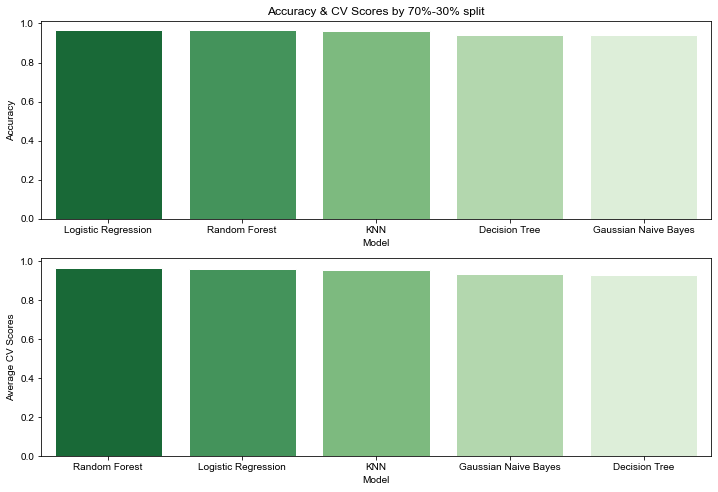

In [23]:
fig, axes=plt.subplots(2, 1, figsize=(12, 8))
sns.set(style="whitegrid", color_codes=True)

pal = sns.color_palette("Greens", len(performances_70_30))
sns.barplot(x='Model', y='Accuracy', data=performances_70_30.sort_values('Accuracy', ascending=False), ax=axes[0], palette=np.array(pal[::-1]))
sns.barplot(x='Model', y='Average CV Scores', data=performances_70_30.sort_values('Average CV Scores', ascending=False), ax=axes[1], palette=np.array(pal[::-1]))
axes[0].set_title(r'Accuracy & CV Scores by 70%-30% split')

# Do the same thing with splitting dataset as 60% training and 40% test

In [24]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.4, random_state=42)

lr=LogisticRegression()                #Logistic Regression Model
dt=DecisionTreeClassifier()            #Decision Tree Classification Model
rf=RandomForestClassifier()            #Radom Forest Classification Model
kn=KNeighborsClassifier()              #KNN Classification Model
gb=GaussianNB()                        #Gaussian Naive Bayes Model

performances_60_40=pd.DataFrame()
performances_60_40['Model']=['Logistic Regression','Decision Tree','Random Forest','KNN','Gaussian Naive Bayes']
performances_60_40['Accuracy']=[model_performance(lr)[0],
                          model_performance(dt)[0],
                          model_performance(rf)[0],
                          model_performance(kn)[0],
                          model_performance(gb)[0]]
performances_60_40['Average CV Scores']=[model_performance(lr)[1],
                                   model_performance(dt)[1],
                                   model_performance(rf)[1],
                                   model_performance(kn)[1],
                                   model_performance(gb)[1]]

performances_60_40

,Model,Accuracy,Average CV Scores
0,Logistic Regression,0.969298,0.957833
1,Decision Tree,0.960526,0.926254
2,Random Forest,0.964912,0.964897
3,KNN,0.956140,0.954324
4,Gaussian Naive Bayes,0.947368,0.933225


Text(0.5, 1.0, 'Accuracy & CV Scores by 60%-40% split')

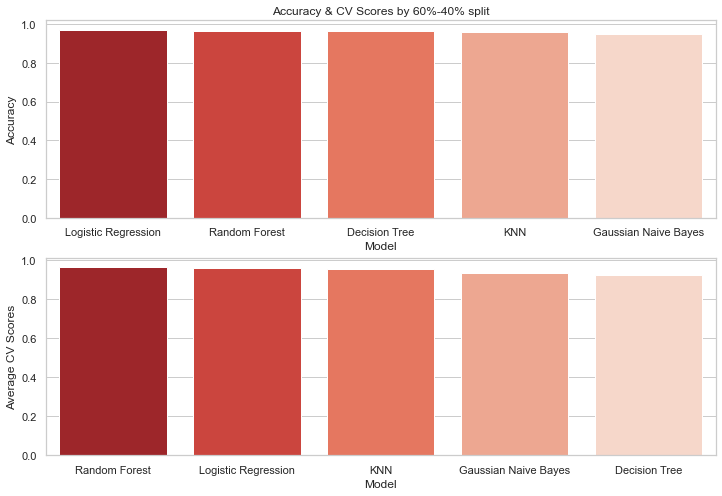

In [25]:
fig, axes=plt.subplots(2, 1, figsize=(12, 8))
sns.set(style="whitegrid", color_codes=True)

pal = sns.color_palette("Reds", len(performances_60_40))
sns.barplot(x='Model', y='Accuracy', data=performances_60_40.sort_values('Accuracy', ascending=False), ax=axes[0], palette=np.array(pal[::-1]))
sns.barplot(x='Model', y='Average CV Scores', data=performances_60_40.sort_values('Average CV Scores', ascending=False), ax=axes[1], palette=np.array(pal[::-1]))
axes[0].set_title(r'Accuracy & CV Scores by 60%-40% split')

# Do the same thing with splitting dataset as 80% training and 20% test

In [26]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)

lr=LogisticRegression()                #Logistic Regression Model
dt=DecisionTreeClassifier()            #Decision Tree Classification Model
rf=RandomForestClassifier()            #Radom Forest Classification Model
kn=KNeighborsClassifier()              #KNN Classification Model
gb=GaussianNB()                        #Gaussian Naive Bayes Model

performances_80_20=pd.DataFrame()
performances_80_20['Model']=['Logistic Regression','Decision Tree','Random Forest','KNN','Gaussian Naive Bayes']
performances_80_20['Accuracy']=[model_performance(lr)[0],
                          model_performance(dt)[0],
                          model_performance(rf)[0],
                          model_performance(kn)[0],
                          model_performance(gb)[0]]
performances_80_20['Average CV Scores']=[model_performance(lr)[1],
                                   model_performance(dt)[1],
                                   model_performance(rf)[1],
                                   model_performance(kn)[1],
                                   model_performance(gb)[1]]

performances_80_20

,Model,Accuracy,Average CV Scores
0,Logistic Regression,0.964912,0.957833
1,Decision Tree,0.929825,0.942059
2,Random Forest,0.964912,0.963127
3,KNN,0.964912,0.954324
4,Gaussian Naive Bayes,0.973684,0.933225


Text(0.5, 1.0, 'Accuracy & CV Scores by 80%-20% split')

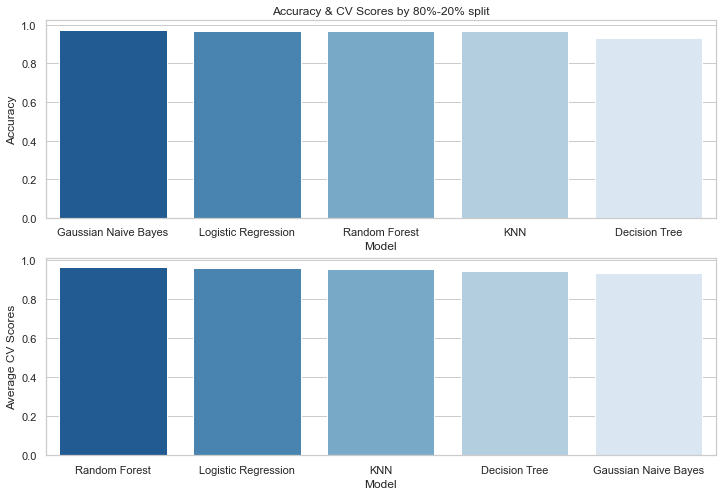

In [27]:
fig, axes=plt.subplots(2, 1, figsize=(12, 8))
sns.set(style="whitegrid", color_codes=True)

pal = sns.color_palette("Blues", len(performances_80_20))
sns.barplot(x='Model', y='Accuracy', data=performances_80_20.sort_values('Accuracy', ascending=False), ax=axes[0], palette=np.array(pal[::-1]))
sns.barplot(x='Model', y='Average CV Scores', data=performances_80_20.sort_values('Average CV Scores', ascending=False), ax=axes[1], palette=np.array(pal[::-1]))
axes[0].set_title(r'Accuracy & CV Scores by 80%-20% split')

In [28]:
performances=pd.concat([performances_70_30, performances_60_40, performances_80_20],ignore_index=True)
performances['Split']=['70-30']*5 + ['60-40']*5 + ['80-20'] * 5

performances

,Model,Accuracy,Average CV Scores,Split
0,Logistic Regression,0.964912,0.957833,70-30
1,Decision Tree,0.941520,0.926223,70-30
2,Random Forest,0.964912,0.964881,70-30
3,KNN,0.959064,0.954324,70-30
4,Gaussian Naive Bayes,0.941520,0.933225,70-30
5,Logistic Regression,0.969298,0.957833,60-40
6,Decision Tree,0.960526,0.926254,60-40
7,Random Forest,0.964912,0.964897,60-40
8,KNN,0.956140,0.954324,60-40
9,Gaussian Naive Bayes,0.947368,0.933225,60-40


Text(0.5, 1.0, 'Accuracy & CV Scores')

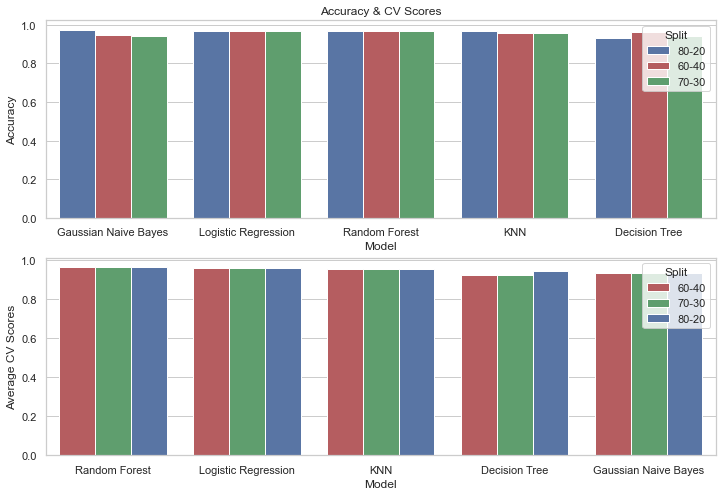

In [29]:
fig, axes=plt.subplots(2, 1, figsize=(12, 8))
sns.set(style="whitegrid", color_codes=True)

palette={'70-30': 'g',
         '60-40': 'r',
         '80-20': 'b'}
sns.barplot(x='Model', y='Accuracy', data=performances.sort_values('Accuracy', ascending=False), ax=axes[0], hue='Split', palette=palette)
sns.barplot(x='Model', y='Average CV Scores', data=performances.sort_values('Average CV Scores', ascending=False), ax=axes[1], hue='Split', palette=palette)
axes[0].set_title(r'Accuracy & CV Scores')


### We can see KNN model with 70-30 split is the best choice.

# Compare different numbers of neighbors of KNN models

In [30]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)

kn5=KNeighborsClassifier(n_neighbors=5)   # 5 neighbors
kn8=KNeighborsClassifier(n_neighbors=8)   # 8 neighbors
kn10=KNeighborsClassifier(n_neighbors=10)   # 10 neighbors

performances_knn=pd.DataFrame()
performances_knn['Model']=['KNN_5','KNN_8','KNN_10']
performances_knn['Accuracy']=[model_performance(kn5)[0],
                          model_performance(kn8)[0],
                          model_performance(kn10)[0]]
performances_knn['Average CV Scores']=[model_performance(kn5)[1],
                                   model_performance(kn8)[1],
                                   model_performance(kn10)[1]]

performances_knn

,Model,Accuracy,Average CV Scores
0,KNN_5,0.959064,0.954324
1,KNN_8,0.970760,0.952554
2,KNN_10,0.970760,0.956063


Text(0.5, 1.0, 'Accuracy & CV Scores by KNNs')

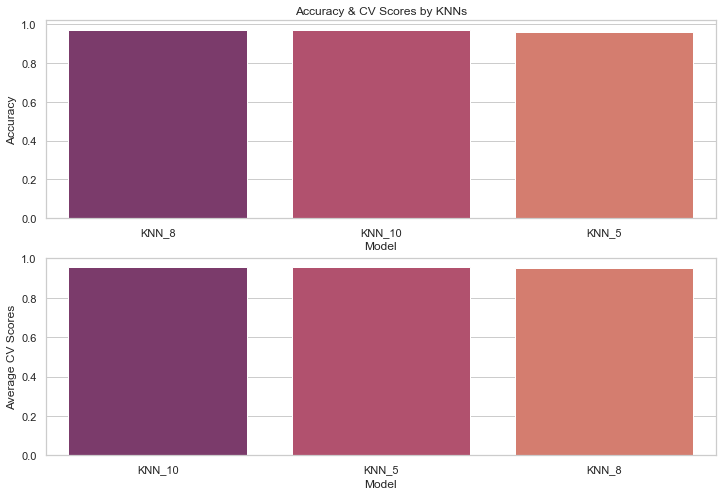

In [31]:
fig, axes=plt.subplots(2, 1, figsize=(12, 8))
sns.set(style="darkgrid", color_codes=True)

pal = sns.color_palette("flare", len(performances_knn))
sns.barplot(x='Model', y='Accuracy', data=performances_knn.sort_values('Accuracy', ascending=False), ax=axes[0], palette=np.array(pal[::-1]))
sns.barplot(x='Model', y='Average CV Scores', data=performances_knn.sort_values('Average CV Scores', ascending=False), ax=axes[1], palette=np.array(pal[::-1]))
axes[0].set_title(r'Accuracy & CV Scores by KNNs')

### Conclusion: The KNN model with 8 neighbors on 70% training - 30% test split is the best choice.